In [37]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

Определение размера контрольной и испытуемой выборок.

In [38]:
effect_size = sms.proportion_effectsize(0.13, 0.15)
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
required_n = ceil(required_n)
print("For each group we need ",required_n, " samples")

For each group we need  4720  samples


# 2. Сбор данных и их подготовка

In [39]:
df = pd.read_csv('ab_test_ensembles.csv')
df.head(5)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [41]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [42]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print('We have {} users, which aren\'t unique'.format({duplicate_users}))

We have {0} users, which aren't unique


Все хорошо, у нас нет пользователей, которые попали в обе группы.

In [43]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=42)

ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.head(5)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,bcf8452b-3056-4d45-994f-5f286fd9869a,2022-05-18 04:44:18.590293,control,standard,0,United Kingdom,42-49,new_user
1,3c827a98-0868-4ce5-ac31-8195e243af37,2022-05-14 05:22:43.771772,control,standard,0,United Kingdom,50-57,new_user
2,71c72bb9-13d9-4755-b398-b2c5d8b1c4d6,2022-05-23 08:52:53.050325,control,standard,0,United Kingdom,34-41,new_user
3,654ee878-b0c5-4223-b9fb-995ca3d2eaf1,2022-05-07 23:27:09.109877,control,standard,0,United Kingdom,26-33,registered_user
4,1e044366-7e86-4d92-bba7-3afaa6f887f8,2022-05-20 14:26:10.133979,control,standard,0,United Kingdom,42-49,new_user


In [44]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    9440 non-null   object
 1   timestamp  9440 non-null   object
 2   group      9440 non-null   object
 3   variants   9440 non-null   object
 4   converted  9440 non-null   int64 
 5   location   9440 non-null   object
 6   age_group  9440 non-null   object
 7   user_type  9440 non-null   object
dtypes: int64(1), object(7)
memory usage: 590.1+ KB


In [45]:
ab_df.group.value_counts(normalize=True)

control      0.5
treatment    0.5
Name: group, dtype: float64

# 3. Визуализация Результатов Эксперимента

In [46]:
conversion_rates = ab_df.groupby('group')['converted']

std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.132415,0.338942,0.004933
treatment,0.119915,0.324862,0.004729


Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя одинаково, за исключением выборочного среднего коэффициента конверсии ~11.99% против ~13.24%

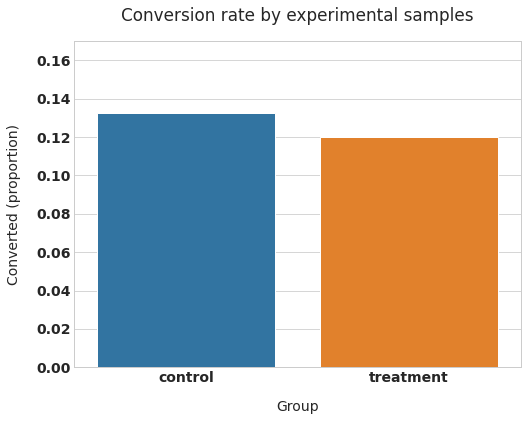

In [47]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df['group'], y=ab_df['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

# 4. Тестирование гипотезы

In [48]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.83
p-value: 0.067
CI 95% for control group: [0.123, 0.142]
CI 95% for treatment group: [0.111, 0.129]


# 5. Интерпритация результатов

Так как наше p-значение = 0.067 что является бОльшим показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наш сайт никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.

Доверительный интервал для испытуемой группы [0.111, 0.129] или 11% и 13% соответственно:
1. Он включает наш baseline
2. Он не достигает нашей цели 15%

Мы можем интерпритировать это как - наиболее вероятно, что реальный уровень конверсии сайта с новым дизайном будет близок к baseline чем к 15%, который мы определили по нашей цели. Таким образом у нас два выбора:
1. Так как мы будем близко к baseline то в случае если сайт воспринимается "красиво" можно его оставить.
2. Можно создать новую версию (потратить время, деньги, нервы) и опять протестировать, надо решать стоят ли затраты на новую версию 2% улучшения (покроются ли затраты на работу) - задача уже финансов, а может и вас :) Считается коэффициент окупаемости и ROI. Если да - можем попробовать еще раз.
3. Ничего не менять.

# 6. Все то же самое, но для групп старых и новых пользователей

In [49]:
df['user_type'].value_counts()

registered_user    147240
new_user           147238
Name: user_type, dtype: int64

In [50]:
old_user_df = df[df['user_type'] == 'registered_user']
new_user_df = df[df['user_type'] == 'new_user']

In [51]:
old_user_df.head(5)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user


In [52]:
new_user_df.head(5)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user
11,1cc7ebbb-efb9-43a6-9230-11161ae910ba,2022-05-21 22:37:47.774891,treatment,svm_ensemble_v_1_22,0,United Kingdom,58+,new_user
14,137d7bf0-309c-4aad-ad9e-302a2f45dc70,2022-05-22 11:45:11.327945,treatment,svm_ensemble_v_1_22,0,United Kingdom,50-57,new_user


# 7. Старые пользователи

In [53]:
control_sample_for_old = old_user_df[old_user_df['group'] == 'control'].sample(n=required_n, random_state=42)
treatment_sample_for_old = old_user_df[old_user_df['group'] == 'treatment'].sample(n=required_n, random_state=42)

ab_df_for_old = pd.concat([control_sample_for_old, treatment_sample_for_old], axis=0)
ab_df_for_old.reset_index(drop=True, inplace=True)
ab_df_for_old.head(5)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,3960d256-ab06-4282-b1bb-1f84a0ad27f4,2022-05-09 10:12:05.412405,control,standard,1,United Kingdom,34-41,registered_user
1,e6d3713e-1f4a-4cab-8186-de2c5bc3c799,2022-05-19 08:49:58.838873,control,standard,0,United Kingdom,26-33,registered_user
2,e4270216-3f3d-4f9e-b615-621709a42625,2022-05-20 20:55:27.488474,control,standard,0,United Kingdom,42-49,registered_user
3,32802f77-5b12-4a02-ad78-d310496ebaea,2022-05-06 14:03:09.808327,control,standard,0,United Kingdom,58+,registered_user
4,e3ea432a-2313-47b0-977d-d2947061bdde,2022-05-04 03:42:37.266315,control,standard,0,United Kingdom,58+,registered_user


In [54]:
ab_df_for_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    9440 non-null   object
 1   timestamp  9440 non-null   object
 2   group      9440 non-null   object
 3   variants   9440 non-null   object
 4   converted  9440 non-null   int64 
 5   location   9440 non-null   object
 6   age_group  9440 non-null   object
 7   user_type  9440 non-null   object
dtypes: int64(1), object(7)
memory usage: 590.1+ KB


In [55]:
ab_df_for_old.group.value_counts(normalize=True)

control      0.5
treatment    0.5
Name: group, dtype: float64

In [56]:
conversion_rates = ab_df_for_old.groupby('group')['converted']

std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.121398,0.326590,0.004754
treatment,0.119280,0.324117,0.004718


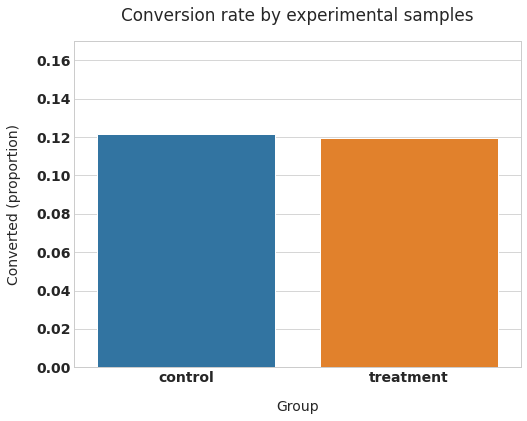

In [57]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df_for_old['group'], y=ab_df_for_old['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [58]:
control_results = ab_df_for_old[ab_df_for_old['group'] == 'control']['converted']
treatment_results = ab_df_for_old[ab_df_for_old['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 0.32
p-value: 0.752
CI 95% for control group: [0.112, 0.131]
CI 95% for treatment group: [0.110, 0.129]


Так как наше p-значение = 0.752 что является бОльшим показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наш сайт никак статистически значимо не влияет на уровень конверсии у уже зарегистрированных пользователей.

# 8. Новые пользователи

In [59]:
control_sample_for_new = new_user_df[new_user_df['group'] == 'control'].sample(n=required_n, random_state=42)
treatment_sample_for_new = new_user_df[new_user_df['group'] == 'treatment'].sample(n=required_n, random_state=42)

ab_df_for_new = pd.concat([control_sample_for_new, treatment_sample_for_new], axis=0)
ab_df_for_new.reset_index(drop=True, inplace=True)
ab_df_for_new.head(5)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,36c2884d-9846-4553-a37f-fa36ce50cb45,2022-05-04 09:13:11.837377,control,standard,0,United Kingdom,34-41,new_user
1,58b4787c-15a1-4fc9-b1b6-a3b61e68e272,2022-05-22 14:59:41.304326,control,standard,1,United Kingdom,18-25,new_user
2,032e7ad0-0822-43c3-bb67-a96b6a52cc52,2022-05-02 17:33:23.178911,control,standard,0,United Kingdom,50-57,new_user
3,05676ce3-4498-47f3-a3f4-56fd04785318,2022-05-11 14:59:29.033575,control,standard,0,United Kingdom,34-41,new_user
4,b696f64f-f2a4-4878-9f22-c53aa82e092a,2022-05-22 05:59:01.010862,control,standard,0,United Kingdom,58+,new_user


In [60]:
ab_df_for_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    9440 non-null   object
 1   timestamp  9440 non-null   object
 2   group      9440 non-null   object
 3   variants   9440 non-null   object
 4   converted  9440 non-null   int64 
 5   location   9440 non-null   object
 6   age_group  9440 non-null   object
 7   user_type  9440 non-null   object
dtypes: int64(1), object(7)
memory usage: 590.1+ KB


In [61]:
ab_df_for_new.group.value_counts(normalize=True)

control      0.5
treatment    0.5
Name: group, dtype: float64

In [62]:
conversion_rates = ab_df_for_new.groupby('group')['converted']

std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.122034,0.327325,0.004764
treatment,0.127331,0.333343,0.004852


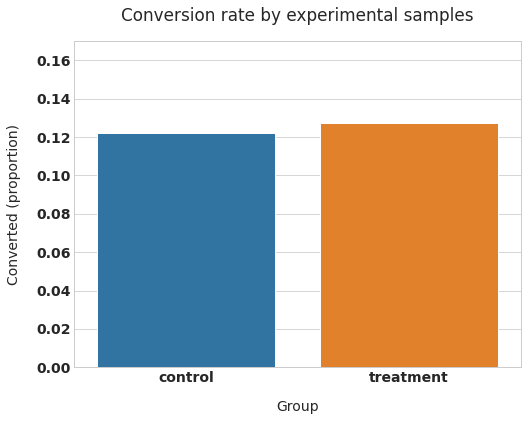

In [63]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df_for_new['group'], y=ab_df_for_new['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [64]:
control_results = ab_df_for_new[ab_df_for_new['group'] == 'control']['converted']
treatment_results = ab_df_for_new[ab_df_for_new['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -0.78
p-value: 0.436
CI 95% for control group: [0.113, 0.131]
CI 95% for treatment group: [0.118, 0.137]


Так как наше p-значение = 0.436 что является бОльшим показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наш сайт никак статистически значимо не влияет на уровень конверсии у новых пользователей.